In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
import zipfile
from cycler import cycler

# global plotting settings
plt.style.use(['ggplot'])

default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
                  cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'axes.labelcolor' : 'black',
                     'yaxis.labellocation' : 'center',
                     'lines.marker' : '.',
                     'lines.linestyle' : 'None',
                     'grid.color' : '.8',
                     'axes.prop_cycle' : default_cycler,
                     'figure.figsize' : (15, 5)
                    })

# plt.rc('axes', prop_cycle=default_cycler)

def extract_ghg(path = './7500-IU/'):
    '''Extracts contents of .ghg files (.data and .metadata files and SmartFlux folders) to same directory'''
    # filepaths_ghg = [f for f in os.listdir(path) if f.endswith('.ghg')]

    filepaths_ghg = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.ghg'):
                filepaths_ghg.append(os.path.join(root, file))

    print(filepaths_ghg)

    for fp in filepaths_ghg:
    #     fp = os.path.join(path, fn)
        with zipfile.ZipFile(fp, "r") as zip_ref:
            zip_ref.extractall(os.path.splitext(fp)[0])

def read_atmos(path = '/home/otto/git/ATMOS484/output/ATMOS484.csv'):
    '''read data output from ATMOS484 package'''
    
    df = (pd.read_csv(path, header=0)
          .assign(date = lambda x: pd.to_datetime(x['datetime'],
                                                format='%Y-%m-%dT%H:%M:%S.%f'))
        .set_index('date')
        .sort_index()
         )
    return df

def read_fluxnet(path = './processedEP/'):

    df = (pd.read_csv(path, header = 0, low_memory=False)
          .replace(-9999, np.nan)
          .assign(date = lambda x: pd.to_datetime(x['TIMESTAMP_END'],
                                                format='%Y%m%d%H%M'))
          .set_index('date')
          .sort_index()
     )
    
    return df

def read_full_output(path = './processedEP/'):
    
    df = (pd.read_csv(path, header=0, skiprows=[0,2], parse_dates=[['date', 'time']])
          .replace(-9999, np.nan)
          .set_index('date_time')
          .sort_index()
     )

    return df

def collectEPfluxnet(path = './processedEP/'):
    filepaths = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.csv'):
                if file.__contains__('eddypro_atmos_fluxnet'):
                    if file.__contains__('2022-06-24') or file.__contains__('2022-07-15') or file.__contains__('2022-08-30') or file.__contains__('2022-10-01') or file.__contains__('2022-10-04'):

                        filepaths.append(os.path.join(root, file))
    # [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("~/files")) for f in fn]

    filepaths.sort()
    print(filepaths)
    def r(i):
        return pd.read_csv(i, header=0)

    # df = pd.read_csv(filepaths[0])
    df = pd.concat(map(r, filepaths[:]))
    
    df = (df.replace(-9999, np.nan)
        .assign(date = lambda x: pd.to_datetime(x['TIMESTAMP_END'],
                                                format='%Y%m%d%H%M'))
        .set_index('date')
        .sort_index()
     )
    
    return df

def collectEPfull(path = './processedEP/'):
    filepaths = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.csv'):
                if file.__contains__('eddypro_atmos_full_output'):
                    if file.__contains__('2022-06-24') or file.__contains__('2022-07-15') or file.__contains__('2022-08-30') or file.__contains__('2022-10-01') or file.__contains__('2022-10-04'):                    
                        filepaths.append(os.path.join(root, file))
    # [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("~/files")) for f in fn]

    filepaths.sort()
    
    def r(i):
        return pd.read_csv(i, header=0, skiprows=[0,2], parse_dates=[['date', 'time']])

    # df = pd.read_csv(filepaths[0])
    df = pd.concat(map(r, filepaths[:]))
    
    df = (df.replace(-9999, np.nan)
#                   .assign(date_time = lambda x: pd.to_datetime(x['TIMESTAMP_END'],
#                                                 format='%Y%m%d%H%M'))

        .set_index('date_time')
        .sort_index()
     )
    
    return df

def collectEPstats(path = './processedEP/20220621', levels = 7, folderstr = 'eddypro_stats', filestr = 'eddypro_atmos_st'):
    filepaths = []
    for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.csv'):
                    if file.__contains__(filestr):
                        filepaths.append(os.path.join(root, file))
# [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("~/files")) for f in fn]

    filepaths.sort()
    print(filepaths)
    def r(i):
        return pd.read_csv(i, header=1, parse_dates=[['date', 'time']])

    # df = pd.read_csv(filepaths[0])
    df = pd.concat(map(r, filepaths[:]))
    
    df = (df.replace(-9999, np.nan)
        .set_index('date_time')
        .sort_index()
     )
    
    return df

## 04-01 - Trimming August EP outputs into two, around fall 40sample

In [9]:
data_dirs = ['/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all/',
             '/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all-40sample/']

filepaths = [os.path.join(dp,f) for dp, dn, fn in os.walk(data_dirs[0]) for f in fn if 'fluxnet' in f]
filepaths.sort()

filepath = [x for x in filepaths if '2023-03-06T233357_exp' in x][0]

df08 = pd.read_csv(filepath)

iend = df08.loc[df08['TIMESTAMP_END']==202209271100].index # should use .values
df08 = df08.loc[0:2734]

fp = f'{data_dirs[0]}eddypro_atmos_fluxnet_2023-03-06T233357_trimmed.csv'
# df08.to_csv(fp, index = False)

filepath = [x for x in filepaths if '2023-03-20T123520_exp' in x][0]


df11 = pd.read_csv(filepath, low_memory = False)
iend = df11.loc[df11['TIMESTAMP_END']==202301261100].index # should use .values
df11 = df11.iloc[4797:]

fp = f'{data_dirs[0]}eddypro_atmos_fluxnet_2023-03-20T123520_trimmed.csv'
# df11.to_csv(fp, index = False)

filepaths = [os.path.join(dp,f) for dp, dn, fn in os.walk(data_dirs[0]) for f in fn if 'full_output' in f]
filepaths.sort()
filepath = [x for x in filepaths if '2023-03-06T233357_exp' in x][0]


df08 = pd.read_csv(filepath, header = 0)
iend = df08.loc[df08['file_info']=='2022-09-27T103000_AIU-2189.ghg'].index.values[0]
df08 = df08[:iend+1]

fp = f'{data_dirs[0]}eddypro_atmos_full_output_2023-03-06T233357_trimmed.csv'
# df08.to_csv(fp, index = False)

filepath = [x for x in filepaths if '2023-03-20T123520_exp' in x][0]


df11 = pd.read_csv(filepath, header = 0, low_memory=False)
istart = df11.loc[df11['file_info']=='2023-01-26T103000_AIU-2189.ghg'].index.values[0]
df11 = pd.concat([df11.iloc[0:2], df11.iloc[istart:]])

fp = f'{data_dirs[0]}eddypro_atmos_full_output_2023-03-20T123520_trimmed.csv'
# df11.to_csv(fp, index = False)

/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all/eddypro_atmos_fluxnet_2023-03-06T233357_exp.csv
/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all/eddypro_atmos_fluxnet_2023-03-20T123520_exp.csv
/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all/eddypro_atmos_full_output_2023-03-06T233357_exp.csv
/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all/eddypro_atmos_full_output_2023-03-20T123520_exp.csv


## EP Time Series 03-21-2023 

### Fluxnet

In [7]:
data_dirs = ['/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all/',
             '/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all-40sample/']

filepaths = [os.path.join(dp,f) for dp, dn, fn in os.walk(data_dirs[0]) for f in fn if 'fluxnet' in f]
filepaths.sort()

df05 = read_fluxnet(filepaths[0])
df07 = read_fluxnet(filepaths[1])
df08 = read_fluxnet(filepaths[2])
df11 = read_fluxnet(filepaths[3])

filepaths = [os.path.join(dp,f) for dp, dn, fn in os.walk(data_dirs[1]) for f in fn if 'fluxnet' in f]
filepaths.sort()
df09 = read_fluxnet(filepaths[0])
df10 = read_fluxnet(filepaths[1])

df = (pd.concat([df05, df07, df08.loc[:'2022-09-27 11:00'], df09, df10, df11.loc['2023-01-26 11:00':]])).sort_index()

fp = f'/home/otto/data/atmos-flux-data/output/csv/atmos-fluxnet-{datetime.now().strftime("%Y%m%d")}.csv'
# df.to_csv(fp)

df.tail()

,TIMESTAMP_START,TIMESTAMP_END,DOY_START,DOY_END,FILENAME_HF,SW_IN_POT,NIGHT,EXPECT_NR,FILE_NR,CUSTOM_FILTER_NR,...,CUSTOM_CH4_MEAN,CUSTOM_RSSI_77_MEAN,CUSTOM_CH4_AUX-1_MEAN,CUSTOM_CH4_AUX-2_MEAN,CUSTOM_CH4_AUX-3_MEAN,CUSTOM_CH4_AUX-4_MEAN,CUSTOM_CH4_TC_1_MEAN,CUSTOM_CH4_TC_2_MEAN,CUSTOM_CH4_TC_3_MEAN,NUM_BIOMET_VARS
date,,,,,,,,,,,,,,,,,,,,,
2023-02-14 08:30:00,202302140800,202302140830,45.3332,45.3541,2023-02-14T080000_AIU-2189.ghg,295.868,0,18000.0,18000.0,18000.0,...,2.13484,55.7605,0.000024,0.000008,0.000025,0.000014,9999.99,9999.99,9999.99,0.0
2023-02-14 09:00:00,202302140830,202302140900,45.3541,45.3749,2023-02-14T083000_AIU-2189.ghg,407.195,0,18000.0,18000.0,18000.0,...,2.11797,54.8473,0.000026,0.000011,0.000027,0.000018,9999.99,9999.99,9999.99,0.0
2023-02-14 09:30:00,202302140900,202302140930,45.3749,45.3957,2023-02-14T090000_AIU-2189.ghg,507.861,0,18000.0,18000.0,18000.0,...,2.13948,55.1146,0.000043,0.000023,0.000045,0.000034,9999.99,9999.99,9999.99,0.0
2023-02-14 10:00:00,202302140930,202302141000,45.3957,45.4166,2023-02-14T093000_AIU-2189.ghg,596.142,0,18000.0,18000.0,18000.0,...,2.14843,54.9151,0.000049,0.000025,0.000051,0.000037,9999.99,9999.99,9999.99,0.0
2023-02-14 10:30:00,202302141000,202302141030,45.4166,45.4374,2023-02-14T100000_AIU-2189.ghg,670.529,0,18000.0,18000.0,18000.0,...,2.15013,54.8900,0.000041,0.000021,0.000043,0.000031,9999.99,9999.99,9999.99,0.0


### Full output

In [9]:
data_dirs = ['/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all/',
             '/home/otto/data/atmos-flux-data/processedEP/20230305-rotate-all-40sample/']

filepaths = [os.path.join(dp,f) for dp, dn, fn in os.walk(data_dirs[0]) for f in fn if 'full_output' in f]
filepaths.sort()

df05 = read_full_output(filepaths[0])
df07 = read_full_output(filepaths[1])
df08 = read_full_output(filepaths[2])
df11 = read_full_output(filepaths[3])

filepaths = [os.path.join(dp,f) for dp, dn, fn in os.walk(data_dirs[1]) for f in fn if 'full_output' in f]
filepaths.sort()
df09 = read_full_output(filepaths[0])
df10 = read_full_output(filepaths[1])

df = (pd.concat([df05, df07, df08.loc[:'2022-09-27 11:00'], df09, df10, df11.loc['2023-01-26 11:00':]])).sort_index()

fp = f'/home/otto/data/atmos-flux-data/output/csv/atmos-full_output-{datetime.now().strftime("%Y%m%d")}.csv'
# df.to_csv(fp)

df.tail()

,filename,DOY,daytime,file_records,used_records,Tau,qc_Tau,H,qc_H,LE,...,co2_signal_strength_7500_mean,ch4_mean,rssi_77_mean,ch4_aux-1_mean,ch4_aux-2_mean,ch4_aux-3_mean,ch4_aux-4_mean,ch4_tc_1_mean,ch4_tc_2_mean,ch4_tc_3_mean
date_time,,,,,,,,,,,,,,,,,,,,,
2023-02-14 08:30:00,2023-02-14T080000_AIU-2189.ghg,45.3541,1.0,18000.0,18000.0,-0.115257,0.0,15.4685,1.0,20.7475,...,103.588,2.13484,55.7605,0.000024,0.000008,0.000025,0.000014,9999.99,9999.99,9999.99
2023-02-14 09:00:00,2023-02-14T083000_AIU-2189.ghg,45.3749,1.0,18000.0,18000.0,-0.192124,0.0,79.1690,0.0,31.7544,...,103.607,2.11797,54.8473,0.000026,0.000011,0.000027,0.000018,9999.99,9999.99,9999.99
2023-02-14 09:30:00,2023-02-14T090000_AIU-2189.ghg,45.3957,1.0,18000.0,18000.0,-0.302091,0.0,135.9410,0.0,29.4699,...,103.612,2.13948,55.1146,0.000043,0.000023,0.000045,0.000034,9999.99,9999.99,9999.99
2023-02-14 10:00:00,2023-02-14T093000_AIU-2189.ghg,45.4166,1.0,18000.0,18000.0,-0.362121,0.0,130.0150,0.0,22.3414,...,103.614,2.14843,54.9151,0.000049,0.000025,0.000051,0.000037,9999.99,9999.99,9999.99
2023-02-14 10:30:00,2023-02-14T100000_AIU-2189.ghg,45.4374,1.0,18000.0,18000.0,-0.349342,0.0,107.8140,0.0,20.7464,...,103.612,2.15013,54.8900,0.000041,0.000021,0.000043,0.000031,9999.99,9999.99,9999.99


## Join biomet with fluxnet and full output

/tmp/ipykernel_6962/1454073695.py:49: DtypeWarning: Columns (1,2,3,201) have mixed types. Specify dtype option on import or set low_memory=False.
  df = (pd.read_csv(path, header=0)


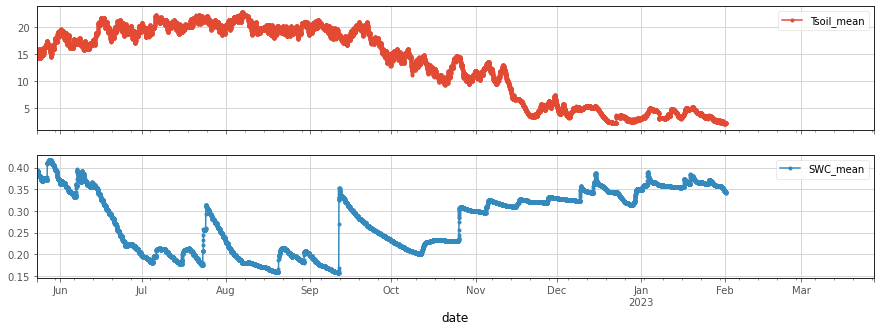

In [12]:
dfflx = read_fluxnet('/home/otto/data/atmos-flux-data/output/csv/atmos-fluxnet-20230401.csv')

dffull = pd.read_csv('/home/otto/data/atmos-flux-data/output/csv/atmos-full_output-20230401.csv')
dffull = (dffull
          .replace(-9999, np.nan)
          .set_index('date_time')
          .sort_index())

atmos = read_atmos()
atmos = atmos.drop(columns = atmos.loc[:, 'filename':'ch4_tc_3_mean'].columns)
atmos.loc[:, 'Tsoil_mean'] = atmos.loc[:, (atmos.columns[atmos.columns.str.contains('Tsoil') & ~atmos.columns.str.contains('cm')])].mean(axis=1)
atmos.loc[:, 'SWC_mean'] = atmos.loc[:, (atmos.columns[atmos.columns.str.contains('SWC') & ~atmos.columns.str.contains('cm')])].mean(axis=1)
atmos.loc[:, atmos.columns.str.contains('mean')].plot(subplots=True)

fp = f'/home/otto/data/atmos-flux-data/output/atmos484_{datetime.now().strftime("%Y%m%d")}_biomet.csv'
# atmos.to_csv(fp)

df = dfflx.join(atmos, how='left')
fp = f'/home/otto/data/atmos-flux-data/output/atmos484_{datetime.now().strftime("%Y%m%d")}_fluxnet.csv'
# df.to_csv(fp)

# df = dffull.join(atmos, how='left') # fails mixed type comparison, datetime columns mixed up
fp = f'/home/otto/data/atmos-flux-data/output/atmos484_{datetime.now().strftime("%Y%m%d")}_full.csv'
# df.to_csv(fp)

In [18]:
dailysum = df.loc[:, ['FC', 'FCH4']].groupby(pd.Grouper(freq='1D')).sum() * 1800 / 1000
dailysum.loc[:, 'LE'] = df.loc[:, ['LE']].groupby(pd.Grouper(freq='1D')).sum()
dailysum

,FC,FCH4,LE
date,,,
2022-05-24,-187.736364,-101.752297,3245.494100
2022-05-25,206.410817,-403.407637,3076.266800
2022-05-26,-333.857290,624.984097,3276.566060
2022-05-27,-94.744256,-615.774096,2156.451616
2022-05-28,-487.860304,-643.314618,5914.534870
...,...,...,...
2023-02-10,-27.927189,18.030515,1288.669987
2023-02-11,-40.529552,21.739516,627.368081
2023-02-12,-23.307245,242.369712,505.794232


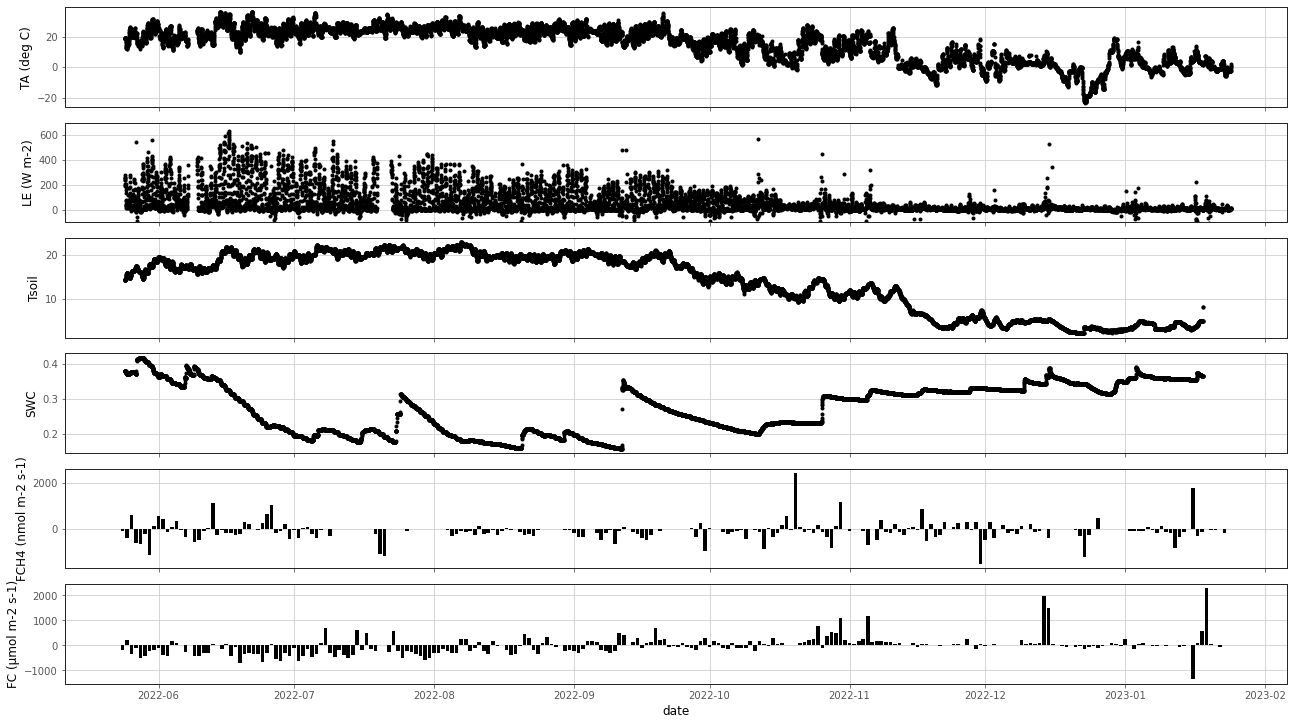

In [25]:
dfp = df.loc[:, ['TA_EP', 'Tsoil_mean', 'LE', 'PA_EP', 'WD', 'SWC_mean', 'FC', 'FCH4']]

fig, ax = plt.subplots(6,1, figsize = (10*1.8, 5.65*1.8), sharex = True)
ax[0].plot(dfp['TA_EP'], color = 'k', linestyle='None')
ax[1].plot(dfp['LE'], color = 'k', linestyle='None')
ax[2].plot(dfp['Tsoil_mean'], color = 'k', linestyle='None')
ax[3].plot(dfp['SWC_mean'], color = 'k', linestyle='None')
ax[4].bar(dailysum.index, dailysum['FCH4'], color = 'k', linestyle='None')
ax[5].bar(dailysum.index, dailysum['FC'], color = 'k', linestyle='None')

ax[0].set(ylabel = 'TA (deg C)')
ax[1].set(ylabel = 'LE (W m-2)', ylim = [-100, 700])
ax[2].set(ylabel = 'Tsoil')
ax[3].set(ylabel='SWC')
ax[4].set(ylabel = 'FCH4 (nmol m-2 s-1)')
ax[5].set(ylabel = 'FC (µmol m-2 s-1)', xlabel = 'date')
plt.tight_layout()
plt.savefig(f'./output/atmos_30mfluxes_{datetime.now().strftime("%Y%m%d%H%M")}.png', dpi=300)

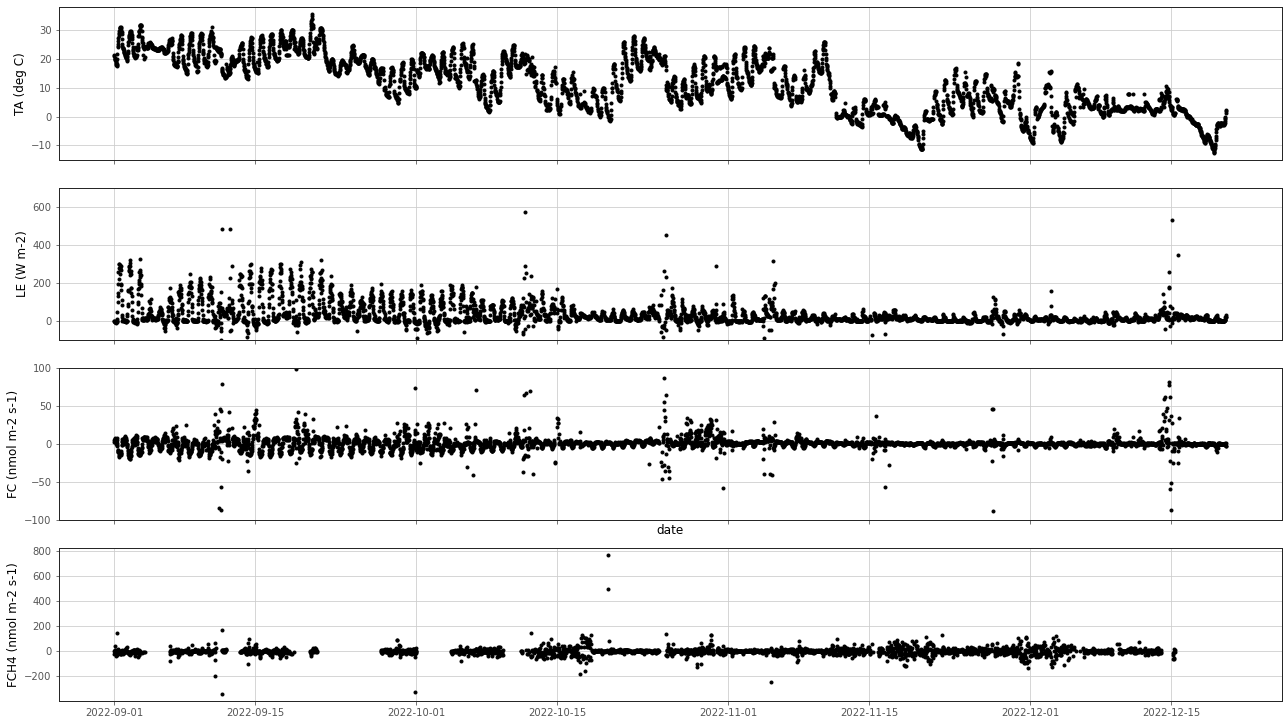

In [55]:
dfp = df.loc['2022-09':, ['TA_EP', 'USTAR', 'PA_EP', 'WD', 'LE', 'FC', 'FCH4']]

fig, ax = plt.subplots(4,1, figsize = (10*1.8, 5.65*1.8), sharex = True)

ax[3].plot(dfp['FCH4'], color = 'k', linestyle='None')
ax[3].set(ylabel = 'FCH4 (nmol m-2 s-1)')

ax[1].plot(dfp['LE'], color = 'k', linestyle='None')
ax[1].set(ylabel = 'LE (W m-2)', ylim = [-100, 700])

ax[0].plot(dfp['TA_EP'], color = 'k', linestyle='None')
ax[0].set(ylabel = 'TA (deg C)')

ax[2].plot(dfp['FC'], color = 'k', linestyle='None')
ax[2].set(ylabel = 'FC (nmol m-2 s-1)', xlabel = 'date', ylim = [-100, 100])
plt.tight_layout()
# plt.savefig('./output/atmos_30mfluxes_2023-01-11_09-12.png', dpi=300)

# 01/11/2023 -filled with random forest

## EP Time Series pre-03/21/2023

In [11]:
df1 = collectEPfluxnet('./processedEP/')
df2 = read_fluxnet('./processedEP/20230109-40sample/eddypro_atmos_fluxnet_2023-01-09T214922_exp.csv')
df3 = read_fluxnet('./processedEP/20230109-40sample2/eddypro_atmos_fluxnet_2023-01-10T095342_exp.csv')
df4 = read_fluxnet('./processedEP/20230124-40sample/eddypro_atmos_fluxnet_2023-01-24T233607_exp.csv')
df5 = read_fluxnet('./processedEP/20230125-40sample/eddypro_atmos_fluxnet_2023-01-25T090006_exp.csv')
df6 = read_fluxnet('./processedEP/20230131-40sample/eddypro_atmos_fluxnet_2023-02-01T091159_exp.csv')
df7 = read_fluxnet('./processedEP/20230131/eddypro_atmos_fluxnet_2023-02-01T014429_exp.csv')
df8 = read_fluxnet('./processedEP/20230217/eddypro_atmos_fluxnet_2023-02-17T132450_exp.csv')
df = (pd.concat([df1.loc[:'2022-09-19 10:30'], df2, df3, df4, df5, df6[:'2023-01-26 09:30'], df7, df8])
      .sort_index())

fp = f'/home/otto/data/atmos-flux-data/output/csv/atmos-fluxnet-{datetime.now().strftime("%Y%m%d")}.csv'
# df.to_csv(fp)

df['FCH4'] 

['./processedEP/20220624/eddypro_atmos_fluxnet_2022-06-24T070349_adv.csv', './processedEP/20220715/eddypro_atmos_fluxnet_2022-07-15T122658_exp.csv', './processedEP/20220829/eddypro_atmos_fluxnet_2022-08-30T001140_exp.csv', './processedEP/20220830/eddypro_atmos_fluxnet_2022-08-30T075857_exp.csv', './processedEP/20221001/eddypro_atmos_fluxnet_2022-10-01T005737_exp.csv', './processedEP/20221004/eddypro_atmos_fluxnet_2022-10-04T190557_exp.csv']


date
2022-05-24 11:30:00          NaN
2022-05-24 12:00:00   -107.28500
2022-05-24 12:30:00      6.68195
2022-05-24 13:00:00     34.02000
2022-05-24 13:30:00     96.51870
                         ...    
2023-02-14 08:30:00     -1.67900
2023-02-14 09:00:00     -1.28857
2023-02-14 09:30:00     -5.68943
2023-02-14 10:00:00     -7.51726
2023-02-14 10:30:00          NaN
Name: FCH4, Length: 12757, dtype: float64

In [11]:
# df = read_fluxnet('./methane_gapfill/data_dir/ATMOS_20230111/gapfilled/rf_predictors_laplace.csv')
df = read_fluxnet('/home/otto/data/atmos-flux-data/methane-gapfill/data_dir/ATMOS_20230123_rf/gapfilled/rf_predictors_laplace.csv')
df

/home/otto/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (488) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,TIMESTAMP_START,TIMESTAMP_END,DOY_START,DOY_END,FILENAME_HF,SW_IN_POT,NIGHT,EXPECT_NR,FILE_NR,CUSTOM_FILTER_NR,...,FCH4_F1,FCH4_F2,FCH4_F3,FCH4_F4,FCH4_F5,FCH4_F6,FCH4_F7,FCH4_F8,FCH4_F9,FCH4_F10
date,,,,,,,,,,,,,,,,,,,,,
2022-05-24 11:30:00,202205241130,202205241200,144.4790,144.4999,not_enough_data,1240.990,0,NaN,NaN,NaN,...,-124.652869,-0.544445,-115.884332,-55.650775,110.073522,79.800425,-87.305360,-71.558890,108.680432,-1.560915
2022-05-24 12:00:00,202205241200,202205241230,144.4999,144.5207,2022-05-24T120000_AIU-2189.ghg,1248.990,0,18000.0,18000.0,18000.0,...,-107.285000,-107.285000,-107.285000,-107.285000,-107.285000,-107.285000,-107.285000,-107.285000,-107.285000,-107.285000
2022-05-24 12:30:00,202205241230,202205241300,144.5207,144.5415,2022-05-24T123000_AIU-2189.ghg,1240.990,0,18000.0,18000.0,18000.0,...,6.681950,6.681950,6.681950,6.681950,6.681950,6.681950,6.681950,6.681950,6.681950,6.681950
2022-05-24 13:00:00,202205241300,202205241330,144.5415,144.5624,2022-05-24T130000_AIU-2189.ghg,1217.130,0,18000.0,18000.0,18000.0,...,34.020000,34.020000,34.020000,34.020000,34.020000,34.020000,34.020000,34.020000,34.020000,34.020000
2022-05-24 13:30:00,202205241330,202205241400,144.5624,144.5832,2022-05-24T133000_AIU-2189.ghg,1177.830,0,18000.0,18000.0,18000.0,...,96.518700,96.518700,96.518700,96.518700,96.518700,96.518700,96.518700,96.518700,96.518700,96.518700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20 09:00:00,202212200900,202212200930,354.3749,354.3957,2022-12-20T090000_AIU-2189.ghg,311.852,0,18000.0,18000.0,18000.0,...,23.434181,-84.401013,-20.939439,87.632351,30.656119,8.458391,-20.661609,50.255665,43.197743,-84.290474
2022-12-20 09:30:00,202212200930,202212201000,354.3957,354.4166,2022-12-20T093000_AIU-2189.ghg,395.748,0,18000.0,18000.0,18000.0,...,33.259117,-76.697876,-8.726490,45.589608,31.859261,5.100845,-31.379853,38.781916,-32.108505,-3.338185
2022-12-20 10:00:00,202212201000,202212201030,354.4166,354.4374,2022-12-20T100000_AIU-2189.ghg,466.440,0,18000.0,18000.0,18000.0,...,17.333672,36.511713,68.459190,-18.641651,43.041471,-37.629003,3.979935,43.266276,-5.822521,-87.809251


In [21]:
dailysum = df.loc[:, ['FC', 'FCH4_F']].groupby(pd.Grouper(freq='1D')).sum() * 1800 / 1000
dailysum.loc[:, 'LE'] = df.loc[:, ['LE']].groupby(pd.Grouper(freq='1D')).sum()
dailysum

,FC,FCH4_F,LE
date,,,
2022-05-24,-187.736364,-130.300875,3245.494100
2022-05-25,206.410817,-333.026656,3076.266800
2022-05-26,-333.857290,594.527860,3276.566060
2022-05-27,-94.744256,-1120.551301,2156.451616
2022-05-28,-487.860304,-776.624996,5914.534870
...,...,...,...
2022-12-16,72.226260,244.207923,1022.084290
2022-12-17,17.716926,-132.187702,793.971420
2022-12-18,-6.598979,-522.065560,535.547660


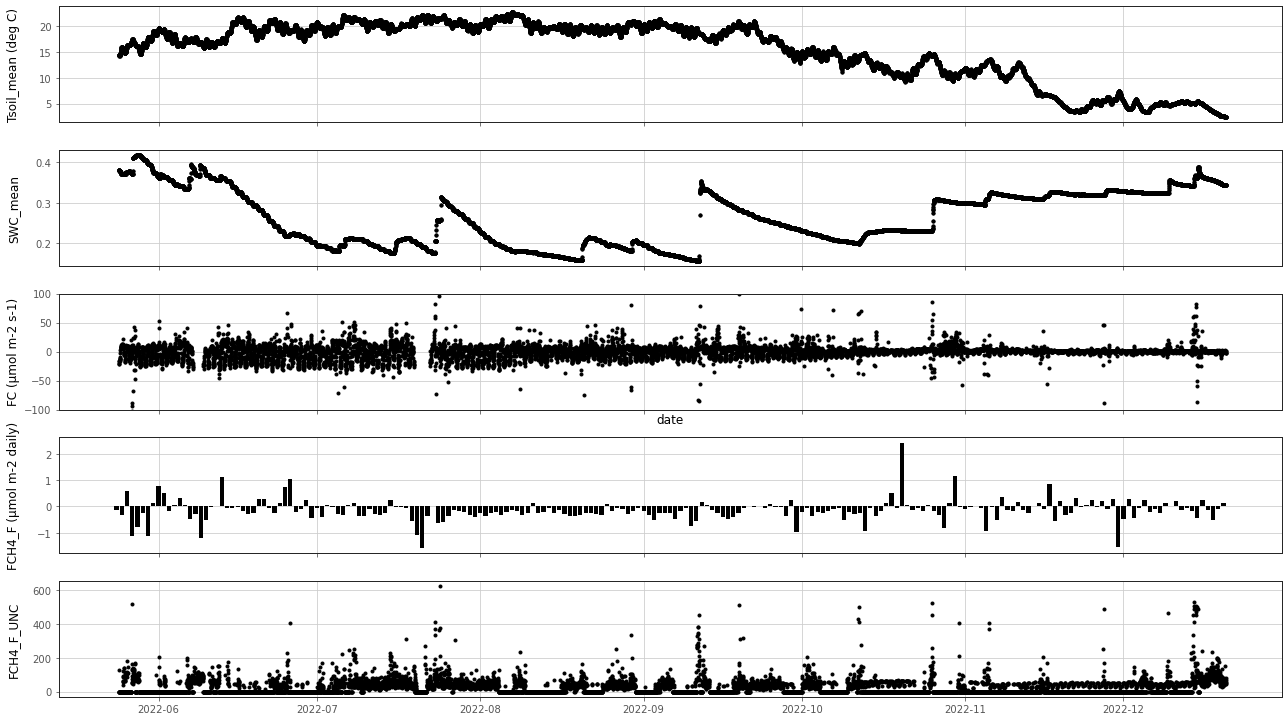

In [74]:
cols = ['Tsoil_mean', 'USTAR', 'PA_EP', 'WD', 'SWC_mean', 'FC', 'FCH4','FCH4_F', 'FCH4_F_UNCERTAINTY', 'SWC_mean', 'Tsoil_mean']
dfp = df.loc[:, cols]

fig, ax = plt.subplots(5,1, figsize = (10*1.8, 5.625*1.8), sharex = True)

ax[0].plot(dfp['Tsoil_mean'], color = 'k', linestyle='None')
ax[0].set(ylabel = 'Tsoil_mean (deg C)')
ax[1].plot(dfp['SWC_mean'], color = 'k', linestyle='None')
ax[1].set(ylabel = 'SWC_mean')
ax[2].plot(dfp['FC'], color = 'k', linestyle='None')
ax[2].set(ylabel = 'FC (µmol m-2 s-1)', xlabel = 'date', ylim = [-100, 100])
ax[3].bar(dailysum.index, dailysum['FCH4_F'] / 1000, color = 'k')
ax[3].set(ylabel = 'FCH4_F (µmol m-2 daily)', ylim = [None,None])
ax[4].plot(dfp['FCH4_F_UNCERTAINTY'], color = 'k', linestyle='None')
ax[4].set(ylabel = 'FCH4_F_UNC')
plt.tight_layout()

# for j in range(len(ax)):
#     ax[j].yaxis.set_label_coords(-0.035, 0.3)
fig.align_ylabels(ax[:])
# plt.show()

plt.savefig(f'./output/atmos_30mfluxes_{datetime.now().strftime("%Y-%m-%d")}_filled.png', dpi=300)

# trimming flux off ATMOS484 output - 01/31/2023

In [12]:
atmos484 = pd.read_csv('/home/otto/data/atmos-flux-data/output/atmos484_20230121114953.csv')
# atmos484 = pd.read_csv('/home/otto/git/ATMOS484/output/ATMOS484.csv')
atmos484

/tmp/ipykernel_7653/3451181368.py:1: DtypeWarning: Columns (500) have mixed types. Specify dtype option on import or set low_memory=False.
  atmos484 = pd.read_csv('/home/otto/data/atmos-flux-data/output/atmos484_20230121114953.csv')


,date,TIMESTAMP_START,TIMESTAMP_END,DOY_START,DOY_END,FILENAME_HF,SW_IN_POT,NIGHT,EXPECT_NR,FILE_NR,...,Tsoil_47,Tsoil_57,Tsoil_56,Tsoil_55,Tsoil_65,Tsoil_66,Tsoil_67,Tsoil_77,Tsoil_mean,SWC_mean
0,2022-05-24 11:30:00,202205241130,202205241200,144.4790,144.4999,not_enough_data,1240.990,0,NaN,NaN,...,14.86,14.80,15.11,13.90,14.85,14.80,15.10,15.20,14.457636,0.380086
1,2022-05-24 12:00:00,202205241200,202205241230,144.4999,144.5207,2022-05-24T120000_AIU-2189.ghg,1248.990,0,18000.0,18000.0,...,14.80,14.73,15.09,13.82,14.80,14.73,15.04,15.11,14.402545,0.380055
2,2022-05-24 12:30:00,202205241230,202205241300,144.5207,144.5415,2022-05-24T123000_AIU-2189.ghg,1240.990,0,18000.0,18000.0,...,14.75,14.70,15.00,13.80,14.80,14.70,15.00,15.10,14.361091,0.380009
3,2022-05-24 13:00:00,202205241300,202205241330,144.5415,144.5624,2022-05-24T130000_AIU-2189.ghg,1217.130,0,18000.0,18000.0,...,14.70,14.61,15.00,13.80,14.70,14.69,14.97,15.03,14.318182,0.379861
4,2022-05-24 13:30:00,202205241330,202205241400,144.5624,144.5832,2022-05-24T133000_AIU-2189.ghg,1177.830,0,18000.0,18000.0,...,14.70,14.60,14.92,13.77,14.70,14.60,14.90,15.00,14.289636,0.379713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10062,2022-12-20 09:00:00,202212200900,202212200930,354.3749,354.3957,2022-12-20T090000_AIU-2189.ghg,311.852,0,18000.0,18000.0,...,2.20,1.90,2.20,1.90,2.10,2.00,2.40,2.10,2.469623,0.343924
10063,2022-12-20 09:30:00,202212200930,202212201000,354.3957,354.4166,2022-12-20T093000_AIU-2189.ghg,395.748,0,18000.0,18000.0,...,2.20,1.90,2.20,1.87,2.10,2.00,2.40,2.10,2.465283,0.343877
10064,2022-12-20 10:00:00,202212201000,202212201030,354.4166,354.4374,2022-12-20T100000_AIU-2189.ghg,466.440,0,18000.0,18000.0,...,2.20,1.90,2.20,1.82,2.10,2.00,2.40,2.10,2.461321,0.343829
10065,2022-12-20 10:30:00,202212201030,202212201100,354.4374,354.4582,2022-12-20T103000_AIU-2189.ghg,522.717,0,18000.0,18000.0,...,2.20,1.90,2.20,1.80,2.10,2.00,2.36,2.10,2.444906,0.343788
